In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

df = pd.read_csv('C:/Users/DEEPANSH/Desktop/lyrics.csv')
df = df[pd.notnull(df['song'])]
df=df[pd.notnull(df['lyrics'])]
print(df)
print(df['lyrics'].apply(lambda x: len(str(x).split(' '))).sum())


D:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


         index                                               song  year  \
0            0                                          ego-remix  2009   
1            1                                       then-tell-me  2009   
2            2                                            honesty  2009   
3            3                                    you-are-my-rock  2009   
4            4                                      black-culture  2009   
5            5                             all-i-could-do-was-cry  2009   
6            6                                 once-in-a-lifetime  2009   
7            7                                            waiting  2009   
8            8                                          slow-love  2009   
9            9                              why-don-t-you-love-me  2009   
10          10                                      save-the-hero  2009   
11          11                                          telephone  2009   
12          12           

51538166


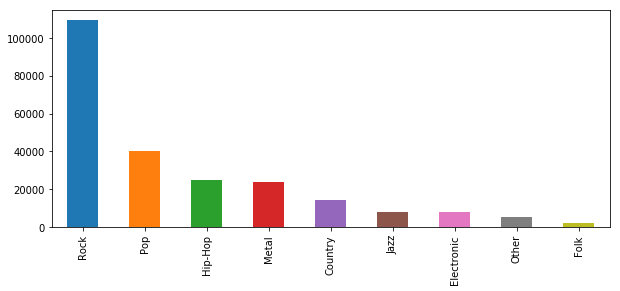

In [3]:
my_tags = ['Country','Jazz','Rock','Metal','Pop','Hip-Hop','Folk','Electronic','Country','Other']
plt.figure(figsize=(10,4))
df.genre.value_counts().plot(kind='bar');

In [4]:
import nltk
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['lyrics'] = df['lyrics'].apply(clean_text)
#print_plot(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df['lyrics'].apply(lambda x: len(x.split(' '))).sum()
df['lyrics'] = df['lyrics'].astype(str)
df['genre'] = df['genre'].astype(str)

In [10]:
X = df.lyrics
y = df.genre
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.4385961621428973


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     Country       0.00      0.00      0.00      3008
        Jazz       0.00      0.00      0.00      1597
        Rock       0.00      0.00      0.00       429
       Metal       0.91      0.19      0.32      5035
         Pop       0.00      0.00      0.00      1663
     Hip-Hop       1.00      0.00      0.01      4609
        Folk       0.00      0.00      0.00      1020
  Electronic       0.39      0.10      0.15      7999
     Country       0.43      0.98      0.60     21785
       Other       0.59      0.04      0.08      6166

   micro avg       0.44      0.44      0.44     53311
   macro avg       0.33      0.13      0.12     53311
weighted avg       0.47      0.44      0.31     53311



In [18]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/DEEPANSH/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [19]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [20]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [21]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\n

[nltk_data]    |   Unzipping corpora\product_reviews_2.zip.
[nltk_data]    | Downloading package pros_cons to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\pros_cons.zip.
[nltk_data]    | Downloading package qc to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\qc.zip.
[nltk_data]    | Downloading package reuters to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    | Downloading package rte to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\rte.zip.
[nltk_data]    | Downloading package semcor to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    | Downloading package senseval to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\senseval.zip.
[nltk_data]    | Downloading package sentiwordnet to
[nlt

[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping misc\perluniprops.zip.
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\nonbreaking_prefixes.zip.
[nltk_data]    | Downloading package vader_lexicon to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    | Downloading package porter_test to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping stemmers\porter_test.zip.
[nltk_data]    | Downloading package wmt15_eval to
[nltk_data]    |     C:\Users\DEEPANSH\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping models\wmt15_eval.zip.
[nltk_data]    | Downloading package mwa_ppdb to
[nltk_data]    |     C:

True

In [22]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['lyrics']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['lyrics']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  


In [25]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['genre'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.genre))
print(classification_report(test.genre, y_pred,target_names=my_tags))

D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5007315517651031
              precision    recall  f1-score   support

     Country       0.41      0.09      0.14      4346
        Jazz       0.25      0.00      0.01      2370
        Rock       0.41      0.02      0.05       658
       Metal       0.72      0.66      0.69      7507
         Pop       0.37      0.04      0.07      2439
     Hip-Hop       0.63      0.43      0.51      7032
        Folk       0.34      0.01      0.01      1512
  Electronic       0.35      0.15      0.21     12042
     Country       0.49      0.89      0.63     32850
       Other       0.33      0.05      0.09      9211

   micro avg       0.50      0.50      0.50     79967
   macro avg       0.43      0.23      0.24     79967
weighted avg       0.46      0.50      0.42     79967



In [11]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_posts = df['lyrics'][:train_size]
train_tags = df['genre'][:train_size]

test_posts = df['lyrics'][train_size:]
test_tags = df['genre'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 167929 samples, validate on 18659 samples
Epoch 1/2
167929/167929 [==============================] - 24s 144us/step - loss: 1.4844 - acc: 0.5033 - val_loss: 1.3980 - val_acc: 0.5326
Epoch 2/2
167929/167929 [==============================] - 24s 141us/step - loss: 1.3931 - acc: 0.5261 - val_loss: 1.3952 - val_acc: 0.5299


In [12]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

79967/79967 [==============================] - 4s 47us/step
Test accuracy: 0.5224780221837783
